## Target validation


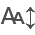

In [17]:
from policyengine_uk import Microsimulation
import pandas as pd
import h5py
import numpy as np
import sys
from itables import init_notebook_mode
from utils import show
import itables.options as opt
from pathlib import Path

opt.maxBytes = "1MB"
init_notebook_mode(all_interactive=True)

REPO = Path(".").resolve().parent

with h5py.File(REPO / "constituencies" / "weights.h5", "r") as f:
    weights = f["weight"][:]

baseline = Microsimulation()
household_weights = baseline.calculate("household_weight", 2025).values

from policyengine_uk_local_areas.loss import create_constituency_target_matrix, create_national_target_matrix

constituency_target_matrix, constituency_actuals = create_constituency_target_matrix("enhanced_frs_2022_23", 2025, None)
national_target_matrix, national_actuals = create_national_target_matrix("enhanced_frs_2022_23", 2025, None)
constituencies_2024 = pd.read_csv(REPO / "policyengine_uk_local_areas" / "constituencies_2024.csv")

constituency_wide = weights @ constituency_target_matrix
constituency_wide.index = constituencies_2024.code.values
constituency_wide["name"] = constituencies_2024.name.values

constituency_results = pd.melt(constituency_wide.reset_index(), id_vars=["index", "name"], var_name="variable", value_name="value")

constituency_actuals.index = constituencies_2024.code.values
constituency_actuals["name"] = constituencies_2024.name.values
constituency_actuals_long = pd.melt(constituency_actuals.reset_index(), id_vars=["index", "name"], var_name="variable", value_name="value")

constituency_target_validation = pd.merge(constituency_results, constituency_actuals_long, on=["index", "variable"], suffixes=("_target", "_actual"))
constituency_target_validation.drop("name_actual", axis=1, inplace=True)
constituency_target_validation.columns = ["index", "name", "metric", "estimate", "target"]

constituency_target_validation["error"] = constituency_target_validation["estimate"] - constituency_target_validation["target"]
constituency_target_validation["abs_error"] = constituency_target_validation["error"].abs()
constituency_target_validation["rel_abs_error"] = constituency_target_validation["abs_error"] / constituency_target_validation["target"]

### Calibration check:
Looking at the sorted validation results by relative absolute error shows how well our calibrated weights perform against the actual target statistics across UK parliamentary constituencies under the new 2024 boundaries. The table reveals the accuracy of our estimates, from the closest matches to the largest discrepancies, where a lower relative error indicates better calibration performance.

In [16]:
constituency_target_validation.sort_values("rel_abs_error")

index                           name  \
3546   E14001359               Mid Bedfordshire   
4396   E14001559  Vauxhall and Camberwell Green   
1633   E14001396                  North Norfolk   
4863   E14001376                        Newbury   
14036  E14001449   Romsey and Southampton North   
...          ...                            ...   
7997   E14001260   Hackney South and Shoreditch   
6738   E14001301                   Ilford South   
7388   E14001301                   Ilford South   
8549   E14001162           Chesham and Amersham   
7899   E14001162           Chesham and Amersham   

                                          metric      estimate        target  \
3546                                   age/30_40  1.327161e+04  1.327200e+04   
4396                                   age/40_50  1.222012e+04  1.221900e+04   
1633                                    age/0_10  1.010078e+04  1.010200e+04   
4863                                   age/50_60  1.402112e+04  1.401900e+04   
14036  hmrc/employment_income/amount/50000_70000  2.839239e+08  2.838722e+08   
...                                          ...           ...           ...   
7997    hmrc/employment_income/count/15000_20000  3.065949e+03  1.853816e+02   
6738    hmrc/employment_income/count/12570_15000  1.097992e+03  6.521896e+01   
7388   hmrc/employment_income/amount/12570_15000  1.519679e+07  8.990434e+05   
8549   hmrc/employment_income/amount/15000_20000  5.369161e+07  3.087762e+06   
7899    hmrc/employment_income/count/15000_20000  3.069817e+03  1.764435e+02   

              error     abs_error  rel_abs_error  
3546  -3.872296e-01  3.872296e-01       0.000029  
4396   1.119535e+00  1.119535e+00       0.000092  
1633  -1.222117e+00  1.222117e+00       0.000121  
4863   2.118543e+00  2.118543e+00       0.000151  
14036  5.163689e+04  5.163689e+04       0.000182  
...             ...           ...            ...  
7997   2.880567e+03  2.880567e+03      15.538586  
6738   1.032773e+03  1.032773e+03      15.835466  
7388   1.429775e+07  1.429775e+07      15.903289  
8549   5.060385e+07  5.060385e+07      16.388519  
7899   2.893373e+03  2.893373e+03      16.398294  

[14300 rows x 8 columns]

In [10]:
national_performance = household_weights @ national_target_matrix
national_target_validation = pd.DataFrame({"metric": national_performance.index, "estimate": national_performance.values})
national_target_validation["target"] = national_actuals.values

national_target_validation["error"] = national_target_validation["estimate"] - national_target_validation["target"]
national_target_validation["abs_error"] = national_target_validation["error"].abs()
national_target_validation["rel_abs_error"] = national_target_validation["abs_error"] / national_target_validation["target"]

The table below shows the relative absolute error for each calibration target at the **national level**, sorted from the closest matches to the largest discrepancies.

In [11]:
national_target_validation.sort_values("rel_abs_error")

metric      estimate  \
32                                     obr/tax_credits  2.943900e+07   
98                                ons/london_age_40_49  1.313667e+06   
264  hmrc/dividend_income_count_income_band_50_150_...  9.831851e+04   
170  hmrc/self_employment_income_count_income_band_...  9.565654e+05   
176  hmrc/property_income_count_income_band_44_20_0...  4.218731e+05   
..                                                 ...           ...   
152  hmrc/dividend_income_count_income_band_42_12_5...  4.643037e+04   
145  hmrc/private_pension_income_income_band_42_12_...  2.558292e+09   
146  hmrc/private_pension_income_count_income_band_...  4.939236e+05   
143  hmrc/state_pension_income_band_42_12_570.0_to_...  5.210198e+09   
144  hmrc/state_pension_count_income_band_42_12_570...  4.697396e+05   

           target         error     abs_error  rel_abs_error  
32  -1.000000e+08  1.294390e+08  1.294390e+08      -1.294390  
98   1.314000e+06 -3.328305e+02  3.328305e+02       0.000253  
264  9.836400e+04 -4.548842e+01  4.548842e+01       0.000462  
170  9.577590e+05 -1.193629e+03  1.193629e+03       0.001246  
176  4.213140e+05  5.591286e+02  5.591286e+02       0.001327  
..            ...           ...           ...            ...  
152  2.021400e+04  2.621637e+04  2.621637e+04       1.296941  
145  1.103045e+09  1.455246e+09  1.455246e+09       1.319299  
146  1.738270e+05  3.200966e+05  3.200966e+05       1.841466  
143  1.819054e+09  3.391144e+09  3.391144e+09       1.864235  
144  1.492520e+05  3.204876e+05  3.204876e+05       2.147292  

[335 rows x 6 columns]